In [1]:
import sys
sys.path.insert(0, "../../../")

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.constants import c, h, m_p

from agnpy.utils.conversion import mpc2
from agnpy.utils.math import axes_reshaper, ftiny, fmax, log10

from agnpy.targets.targets import CMB
from agnpy.emission_regions import Blob
from agnpy.spectra import PowerLaw, ExpCutoffPowerLaw
from agnpy.photo_meson.photo_meson import PhotoMesonProduction
from agnpy.photo_meson.kernels import PhiKernel, log_interp, secondaries, eta_0

In [2]:
def part_label(particle):
    label = particle
    if particle == "muon_antineutrino":
        label = r"$\bar{\nu}_{\mu}$"
    if particle == "muon_neutrino":
        label = r"$\nu_{\mu}$"
    if particle == "electron_neutrino":
        label = r"$\nu_{e}$"
    if particle == "electron_antineutrino":
        label = r"$\bar{\nu}_{e}$"
    if particle == "gamma":
        label = r"$\gamma$"
    if particle == "electron":
        label = r"e$^{-}$"
    if particle == "positron":
        label = r"e$^{+}$"
    return label

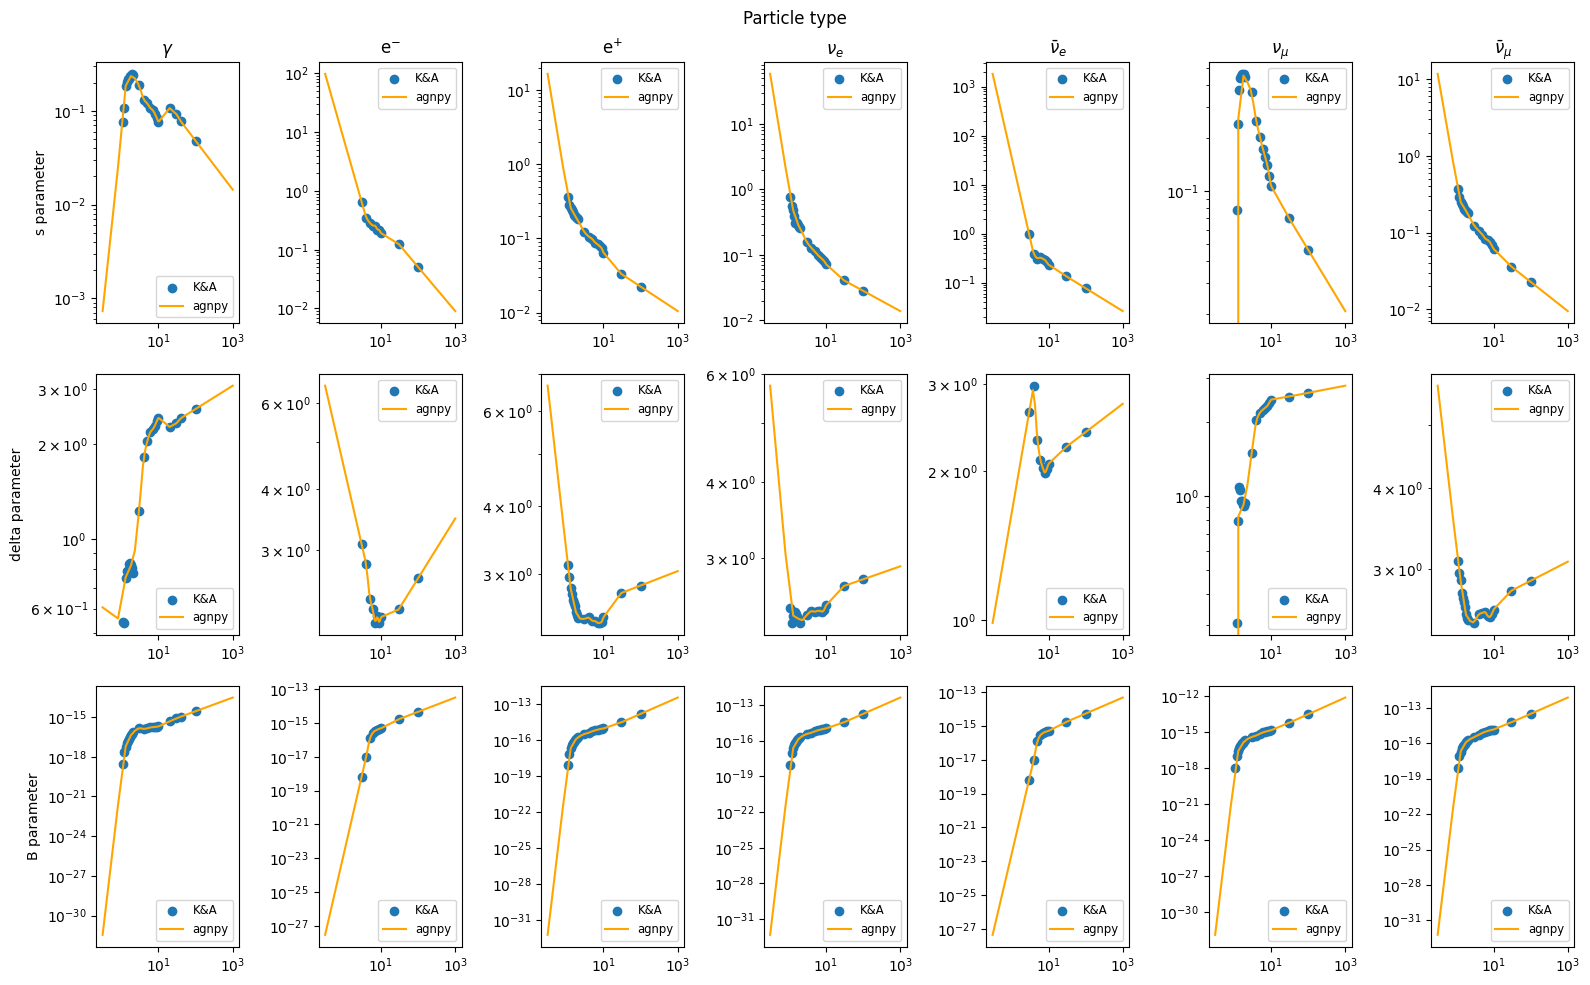

In [3]:
"""
Comparison values of parameters from [KelnerAharonian2008] and their logspace interpolation 
"""

fig, ax = plt.subplots(3,7,figsize = (16, 10))

eta_val = np.linspace(eta_0,1000.0,2000)

fig.suptitle("Particle type")

i = 0
for particle in secondaries:
    interp_file = (
        f"../../data/photo_meson/kelner_aharonian_2008/phi_tables/{particle}.txt"
    )

    eta_eta0, s, delta, B = np.genfromtxt(
        interp_file, dtype="float", comments="#", usecols=(0, 1, 2, 3), unpack="True"
    )

    label = part_label(particle)

    ax[0,i].set_title(label)
    
    ax[0,i].scatter(eta_eta0,s,label=r"K&A")
    ax[1,i].scatter(eta_eta0,delta,label=r"K&A")
    ax[2,i].scatter(eta_eta0,B,label=r"K&A")

    s_val_log = log_interp(eta_val, eta_eta0, s)
    delta_val_log = log_interp(eta_val, eta_eta0, delta)
    B_val_log = log_interp(eta_val, eta_eta0, B)

    ax[0,i].loglog(eta_val,s_val_log,c="orange",label="agnpy")
    ax[1,i].loglog(eta_val,delta_val_log,c="orange",label="agnpy")
    ax[2,i].loglog(eta_val,B_val_log,c="orange",label="agnpy")

    for j in range(0,3):
        ax[j,i].set_xscale('log')
        ax[j,i].set_yscale('log')
        ax[j,i].legend(fontsize = "small")
    
    i=i+1

ax[0,0].set_ylabel("s parameter")
ax[1,0].set_ylabel("delta parameter")
ax[2,0].set_ylabel("B parameter")

fig.tight_layout()

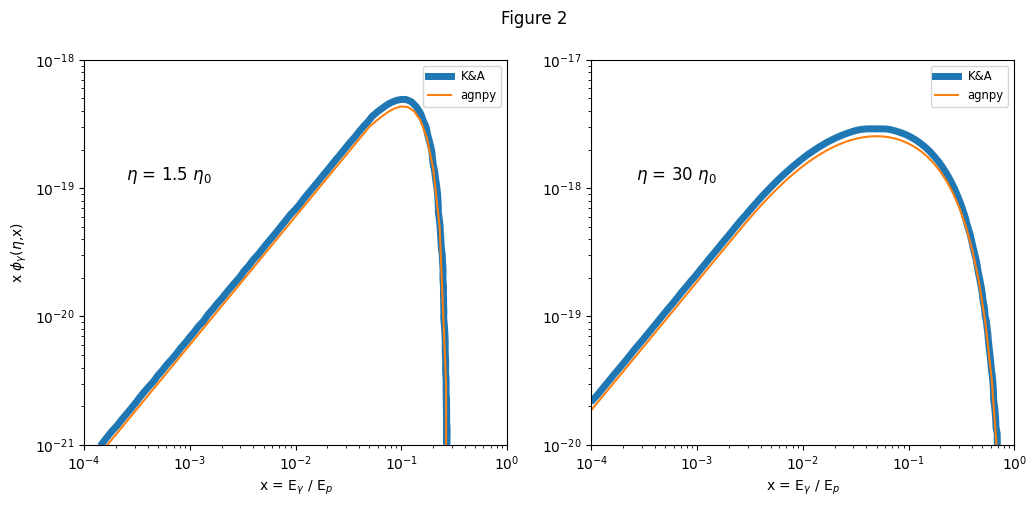

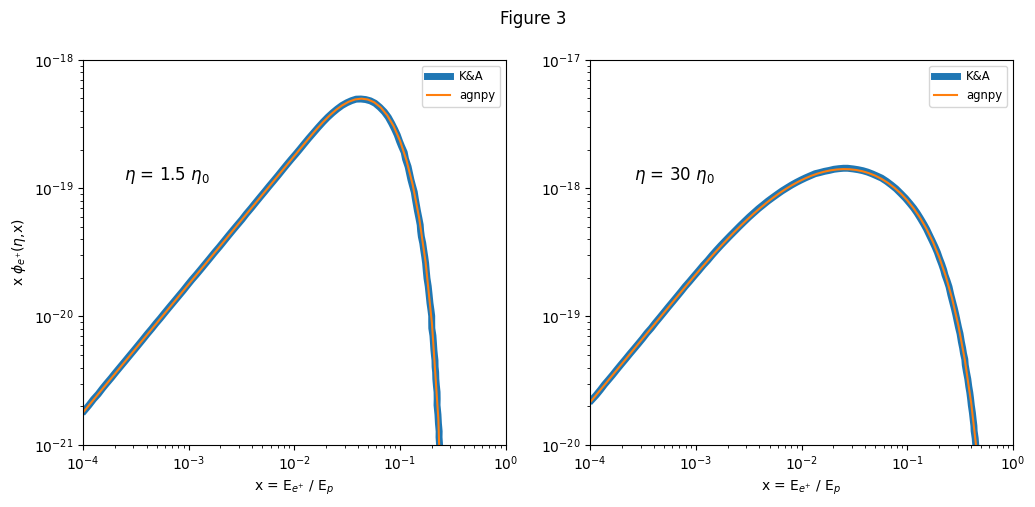

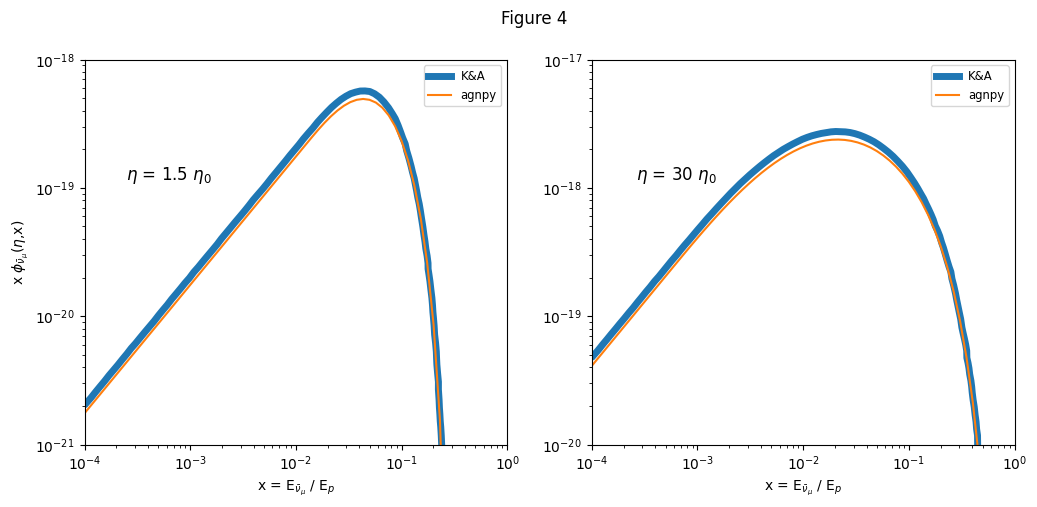

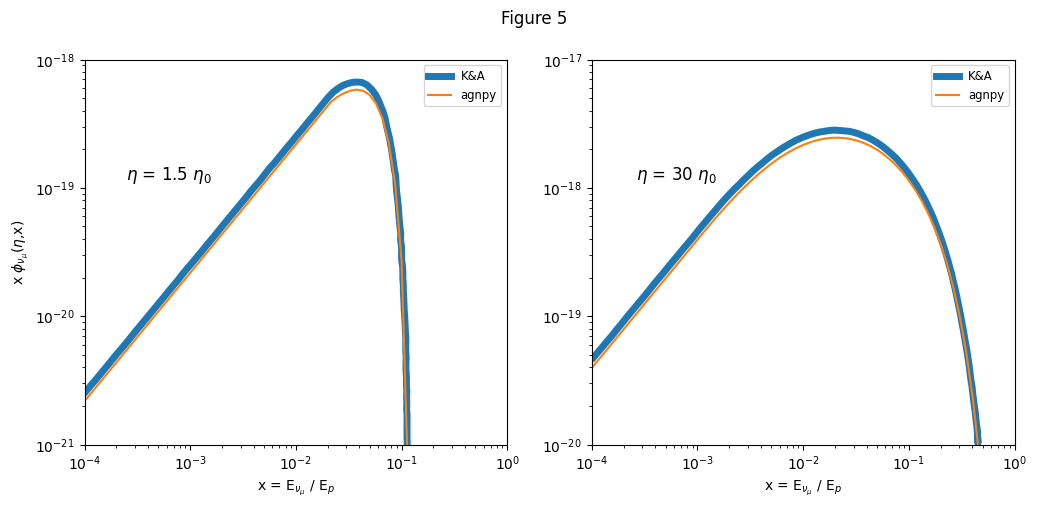

In [4]:
"""
[KelnerAharonian2008] figure 2, 3, 4, 5
"""

def xphi_plot(fig_number):

    if fig_number == "2":
        particle = "gamma"
        label = r"\gamma"
    if fig_number == "3":
        particle = "positron"
        label = r"e^{+}"
    if fig_number == "4":
        particle = "muon_antineutrino"
        label = r"\bar{\nu}_{\mu}"
    if fig_number == "5":
        particle = "muon_neutrino"
        label = r"\nu_{\mu}"

    x = np.logspace(-5,1,100)

    phi_kernel = PhiKernel(particle)

    fig, ax = plt.subplots(1,2,figsize = (12, 5))

    fig.suptitle(f"Figure {fig_number}")

    param_tab = ["1.5","30"]

    i = 0
    for parameter in param_tab:
        interp_file = (
            f"../../data/photo_meson/kelner_aharonian_2008/fig{fig_number}_values/{particle}_{parameter}eta0.txt"
        )

        x_i, spectrum = np.genfromtxt(
            interp_file, dtype="float", comments="#", usecols=(0, 1), unpack="True"
        )

        x_i = np.power(10,x_i)
        spectrum = np.power(10,spectrum)

        ax[i].loglog(x_i,spectrum,lw=5,label=r"K&A")

        eta = float(parameter)*eta_0
        ax[i].loglog(x,x*phi_kernel(eta,x),label="agnpy")

        ax[i].set_xlim(1e-4,1e0)

        if parameter == "1.5":
            ax[i].set_ylim(1e-21,1e-18)
            ax[i].set_ylabel(rf"x $\phi_{{{label}}}$($\eta$,x)")
        if parameter == "30":
            ax[i].set_ylim(1e-20,1e-17)
            
        ax[i].set_xlabel(rf"x = E$_{{{label}}}$ / E$_p$")
        ax[i].text(0.2, 0.7, rf"$\eta$ = ${{{parameter}}}$ $\eta_{0}$", fontsize=12, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)
        ax[i].legend(fontsize = "small")

        i=i+1

for i in range(2,6):
    xphi_plot(str(i))

In [5]:
cmb = CMB(z = 0.0)
cmb_target = lambda nu: cmb.du_dnu(nu)

def dNdx(x, E_p, particle):

    epsilon0 = (eta_0 * mpc2**2 / (4 * E_p)).to_value("eV")
    eps_val = np.logspace(
        np.log10(epsilon0),
        np.log10(epsilon0) + 8,
        100
    )  * u.Unit("eV")  

    _eps, _x = axes_reshaper(eps_val, x)

    nu = (_eps / h).to("Hz")
    fph = cmb_target(nu)                    

    eta = 4.0 * _eps * E_p / mpc2**2          

    phi_kernel = PhiKernel(particle)
    phi = phi_kernel(eta, _x)               

    integrand = (fph * phi).to_value("1 / (erg s)")

    result = np.trapz(
        integrand,
        x=_eps.to_value("erg"),
        axis=0
    ) * u.Unit("1 / s")                    

    return result

/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: divide by zero encountered in log
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_115057/3966634938.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  result = np.trapz(
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in ex

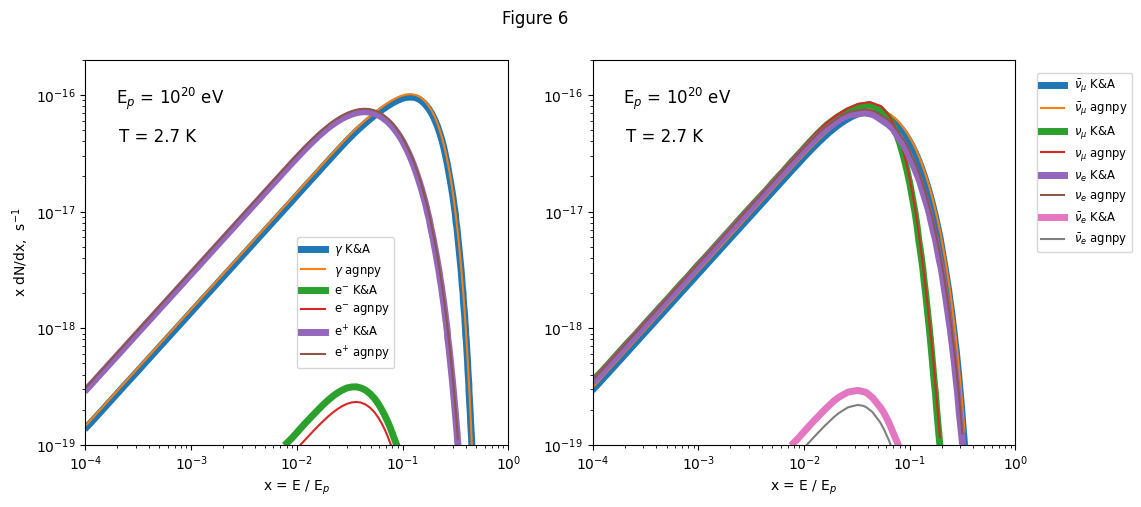

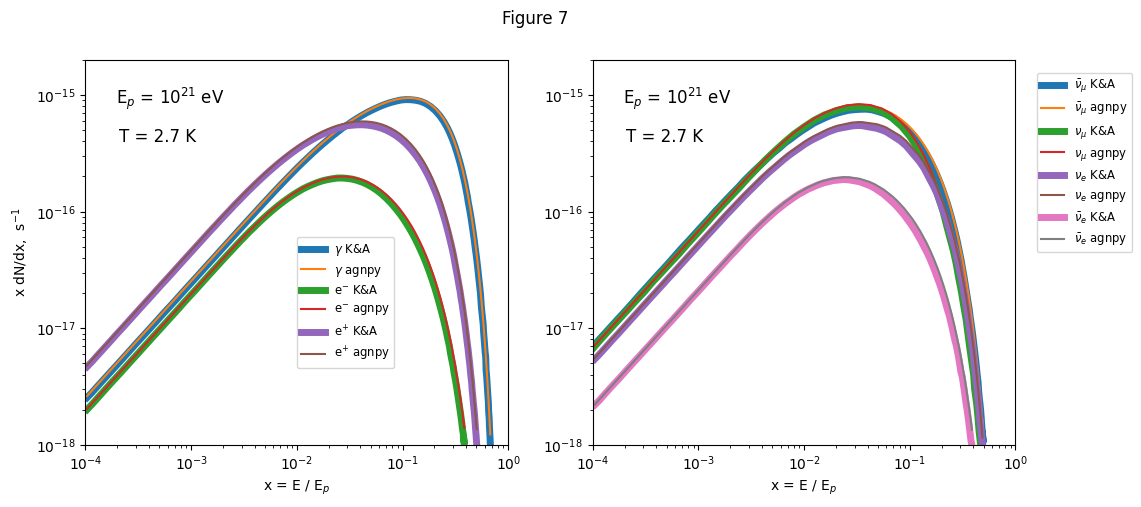

In [6]:
"""
[KelnerAharonian2008] figure 6, 7
"""

def dNdx_plot(fig_number):

    particles_left = ["gamma", "electron", "positron"]
    particles_right = ["muon_antineutrino", "muon_neutrino", "electron_neutrino", "electron_antineutrino"]

    if fig_number == "6":
        E_p = 1e20 * u.Unit("eV")
        powlabel = "20"
    if fig_number == "7":
        E_p = 1e21 * u.Unit("eV")
        powlabel = "21"

    fig, ax = plt.subplots(1,2,figsize = (12, 5))

    fig.suptitle(f"Figure {fig_number}")

    for particle in particles_left:
        interp_file = (
            f"../../data/photo_meson/kelner_aharonian_2008/fig{fig_number}_values/{particle}.txt"
        )
        
        x_i, spectrum = np.genfromtxt(
            interp_file, dtype="float", comments="#", usecols=(0, 1), unpack="True"
        )

        x_i = np.power(10,x_i)
        spectrum = np.power(10,spectrum)
        
        label = part_label(particle)+" K&A"

        ax[0].loglog(x_i,spectrum,lw=5,label=label)

        label = part_label(particle)+" agnpy"

        ax[0].loglog(x_i, x_i*dNdx(x_i,E_p,particle),label=label)

    for particle in particles_right:
        interp_file = (
            f"../../data/photo_meson/kelner_aharonian_2008/fig{fig_number}_values/{particle}.txt"
        )
        
        x_i, spectrum = np.genfromtxt(
            interp_file, dtype="float", comments="#", usecols=(0, 1), unpack="True"
        )

        x_i = np.power(10,x_i)
        spectrum = np.power(10,spectrum)

        label = part_label(particle)+" K&A"
        
        ax[1].loglog(x_i,spectrum,lw=5,label=label)

        label = part_label(particle)+" agnpy"

        ax[1].loglog(x_i, x_i*dNdx(x_i,E_p,particle), label=label)

    for ax_i in ax:
        ax_i.set_xlim(1e-4,1e0)


    if fig_number == "6":
        for axi in ax:
            axi.set_ylim(1e-19,2e-16)
        
    if fig_number == "7":
        for axi in ax:
            axi.set_ylim(1e-18,2e-15)
            
    for axi in ax:
        axi.set_xlim(1e-4,1e0)
        axi.set_xlabel(r"x = E / E$_{p}$")
        axi.text(0.17, 0.8, r"T = 2.7 K", fontsize=12, horizontalalignment='center', verticalalignment='center', transform=axi.transAxes)
        axi.text(0.2, 0.9, rf"E$_{{p}}$ = 10$^{{{powlabel}}}$ eV", fontsize=12, horizontalalignment='center', verticalalignment='center', transform=axi.transAxes)

    ax[0].set_ylabel(r"x dN/dx,  s$^{-1}$")
    
    ax[0].legend(loc=(0.5,0.2),fontsize = "small")
    ax[1].legend(loc=(1.05,0.5),fontsize = "small")

for i in range(6,8):
    dNdx_plot(str(i))

In [7]:
def plot_spectrum (E, spectrum, particle, power = 1, lw=1, from_tab = False, fig = None, ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize = (8, 6))

    if from_tab == False:
        label = part_label(particle)+" agnpy"
    
        ax.loglog(
            E.to("eV"),
            (spectrum * E**power).to(f"erg{power-1} cm-3 s-1"), 
            label = label
        )
    else:
        label = part_label(particle)+" K&A"
            
        ax.loglog(
            E.to("eV"),
            (spectrum).to(f"cm-3 s-1"), 
            label = label,
            lw=lw
        )

    ax.set_xlabel("E [eV]")
    if power == 0:
        ylabel = "$\\frac{dN}{dE}$ [erg$^{-1}$ cm$^{-3}$ s$^{-1}$]"
    elif power == 1:
        ylabel = "E $\\frac{dN}{dE}$ [cm$^{-3}$ s$^{-1}$]"
    elif power == 2:
        ylabel = "E$^{2}$ $\\frac{dN}{dE}$ [erg cm$^{-3}$ s$^{-1}$]"
    ax.set_ylabel(ylabel)
    
    return fig, ax

Proton energy density =  1.0 erg / cm3


/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: divide by zero encountered in log
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: ove

Proton energy density =  0.9999999999999998 erg / cm3


/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: divide by zero encountered in log
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: ove

Proton energy density =  1.0 erg / cm3


/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: divide by zero encountered in log
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: ove

Proton energy density =  1.0 erg / cm3


/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: divide by zero encountered in log
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:648: RuntimeWarning: ove

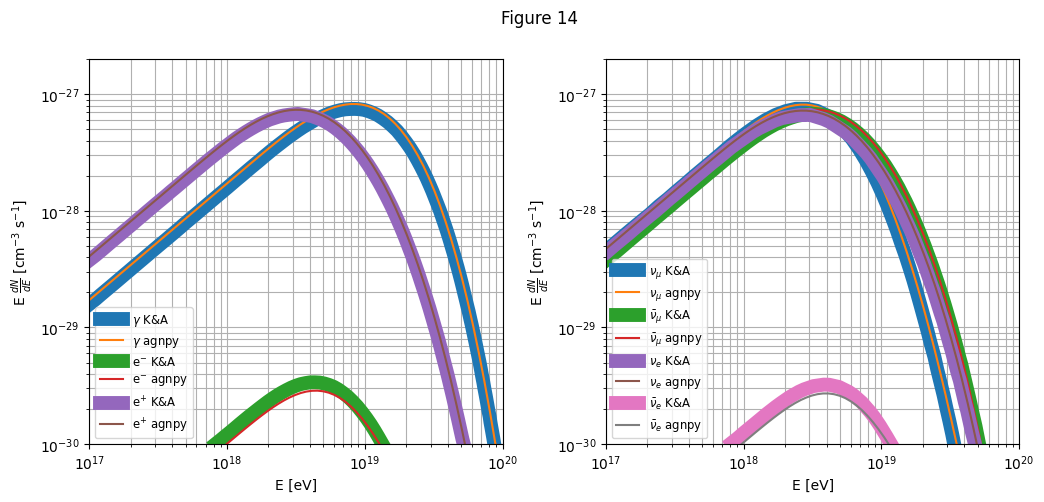

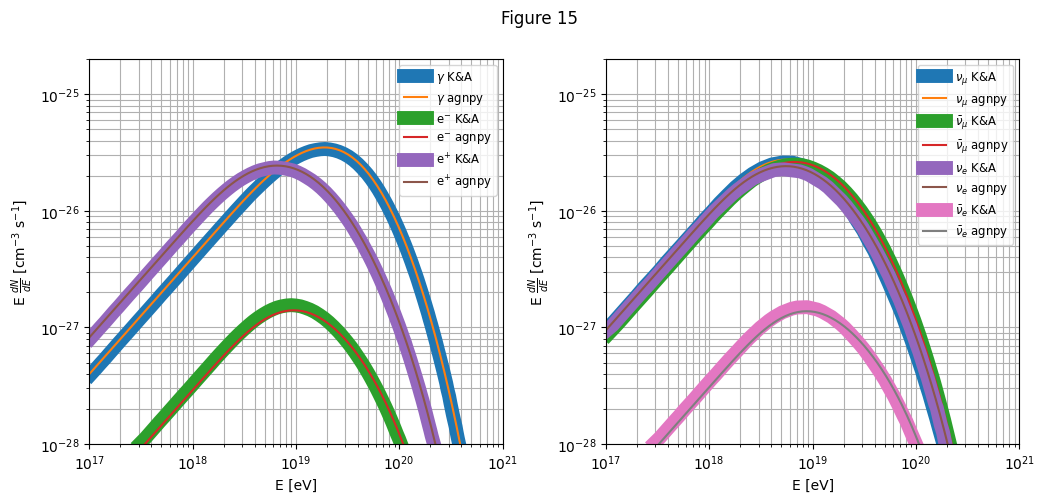

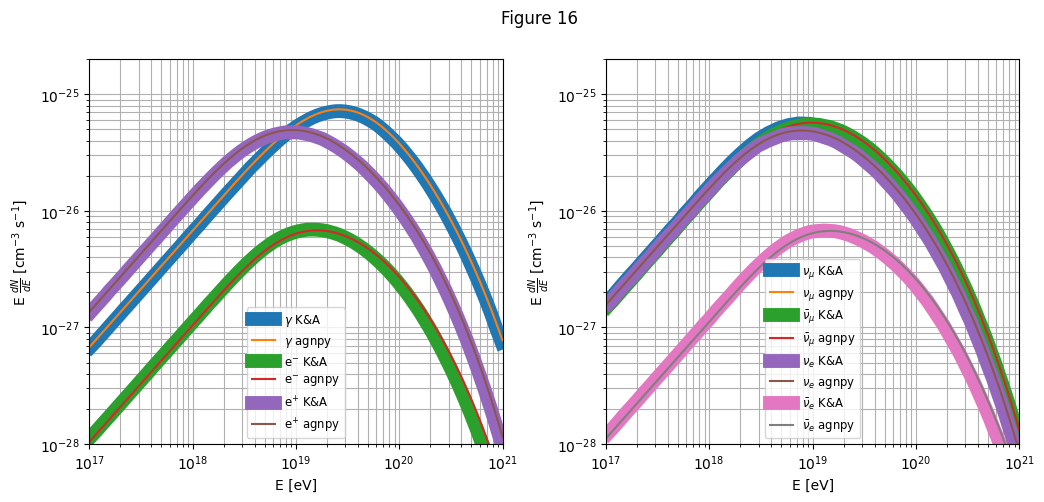

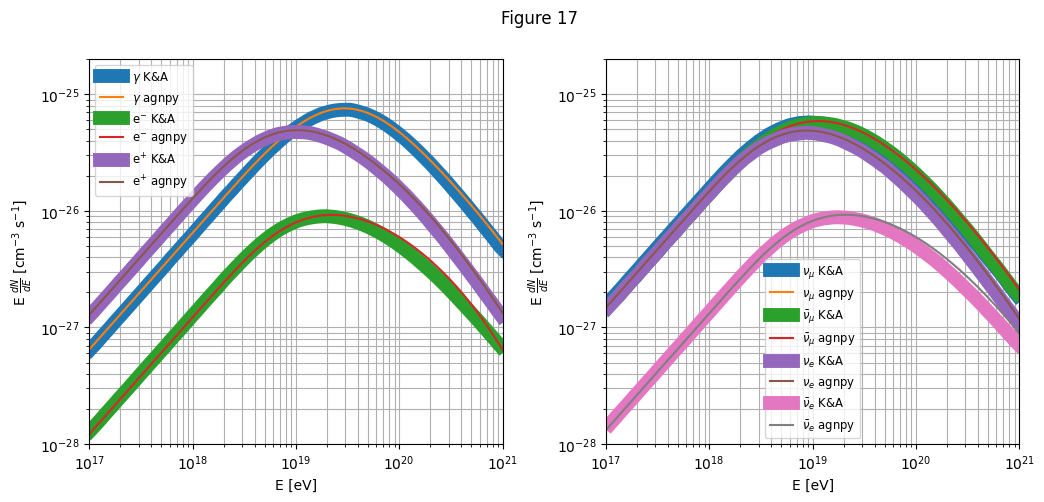

In [8]:
"""
[KelnerAharonian2008] figure 14, 15, 16, 17
"""

numbers = ["14","15","16","17"]
factor = 1.0

for fig_number in numbers:
    
    if fig_number == "14":
        factor = 1e-1
    if fig_number == "15":
        factor = 1e0
    if fig_number == "16":
        factor = 1e1
    if fig_number == "17":
        factor = 1e3

    # Blob with proton population
    E_star = 3e20 * u.Unit("eV")
    gamma_star = (E_star / mpc2).to_value("")

    n_p = ExpCutoffPowerLaw.from_total_energy_density(
        1.0*u.Unit("erg/cm3"),
        mass = m_p,
        p = 2,
        gamma_c = factor*gamma_star, # change fig_number!
        gamma_min = (1.0*u.Unit("GeV")/mpc2).to_value(""),
        gamma_max = 30.0*factor*gamma_star
        )

    blob = Blob(n_p = n_p)
    print ("Proton energy density = ", blob.u_p)

    pmp_cmb = PhotoMesonProduction(blob, cmb_target)
    E = np.logspace(17, 21, 100) * u.Unit("eV")
    particles_left = ["gamma", "electron", "positron"]
    particles_right = ["muon_neutrino", "muon_antineutrino", "electron_neutrino", "electron_antineutrino"]

    fig, axs = plt.subplots(1, 2, figsize = (12, 5))
    fig.subplots_adjust(wspace = 0.25)

    fig.suptitle(f"Figure {fig_number}")

    for particle in particles_left:
        E_i, spectrum= np.genfromtxt("../../data/photo_meson/kelner_aharonian_2008/fig{}_values/{}.txt".format(fig_number,particle), 
                            dtype="float", 
                            comments="#", 
                            usecols=(0, 1), 
                            unpack="True")

        E_i = np.power(10,E_i)*u.Unit("eV")
        spectrum = np.power(10,spectrum)*u.Unit("cm-3 s-1")
        plot_spectrum(E = E_i, spectrum = spectrum, power = 1, particle = particle, lw=10, from_tab=True, fig = fig, ax = axs[0])
        
        spectrum = pmp_cmb.evaluate_spectrum(E, particle = particle)
        plot_spectrum(E = E, spectrum = spectrum, power = 1, particle = particle, fig = fig, ax = axs[0])
        
    for particle in particles_right:
        E_i, spectrum= np.genfromtxt("../../data/photo_meson/kelner_aharonian_2008/fig{}_values/{}.txt".format(fig_number,particle), 
                            dtype="float", 
                            comments="#", 
                            usecols=(0, 1), 
                            unpack="True")

        E_i = np.power(10,E_i)*u.Unit("eV")
        spectrum = np.power(10,spectrum)*u.Unit("cm-3 s-1")
        plot_spectrum(E = E_i, spectrum = spectrum, power = 1, particle = particle, lw=10, from_tab=True, fig = fig, ax = axs[1])
        
        spectrum = pmp_cmb.evaluate_spectrum(E, particle = particle)
        plot_spectrum(E = E, spectrum = spectrum, power = 1, particle = particle, fig = fig, ax = axs[1])

    for ax in axs:
        if fig_number=="14":
            ax.set_xlim(1e17,1e20)
            ax.set_ylim(1e-30,2e-27)
        else:
            ax.set_xlim(1e17,1e21)
            ax.set_ylim(1e-28,2e-25)
        ax.grid(which = "both")
        ax.legend(fontsize = "small")